In [65]:
!unzip 'drive/My Drive/Self_Driving_Car_Project/driving_dataset.zip'

Archive:  drive/My Drive/Self_Driving_Car_Project/driving_dataset.zip
replace driving_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [66]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image

In [67]:
data=pd.read_csv('driving_dataset/data.txt',sep=' ')

In [68]:
data.head(n=5)

,0.jpg,0.000000
0,1.jpg,0.0
1,2.jpg,0.0
2,3.jpg,0.0
3,4.jpg,0.0
4,5.jpg,0.0


In [69]:
data=data.values
x_data=data[:,0]
y_data=data[:,1]
print(x_data.shape,y_data.shape)

(45405,) (45405,)


In [70]:
split=int(data.shape[0]*0.8)
x_train=x_data[:split]
x_test=x_data[split:]
y_train=y_data[:split]
y_test=y_data[split:]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(36324,) (36324,)
(9081,) (9081,)


In [71]:
temp=list(zip(x_train,y_train))
np.random.shuffle(temp)
x_train,y_train=zip(*temp)

temp2=list(zip(x_test,y_test))
np.random.shuffle(temp2)
x_test,y_test=zip(*temp2)

In [72]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [73]:
y_train=y_train*(np.pi/180)
y_test=y_test*(np.pi/180)

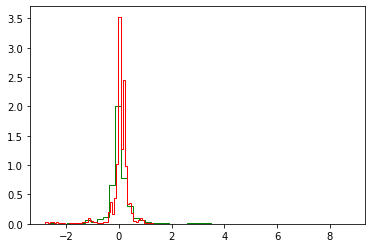

In [74]:
plt.hist(y_train, bins=50, density=True, color='green', histtype ='step');
plt.hist(y_test, bins=50, density=True, color='red', histtype ='step');
plt.show()

In [81]:
def get_input(img_path):
    img_data=image.load_img(img_path,color_mode='rgb')
    img_data=image.img_to_array(img_data)
    img_data=img_data[76:,:,:]
    img_data=cv2.resize(img_data,(200,200))
    img_data=img_data/255.0
    #img_data=cv2.cvtColor(img_data,cv2.COLOR_BGR2YUV)
    #resized_image = cv2.resize((cv2.cvtColor(img_data, cv2.COLOR_RGB2HSV))[:, :, 2], (200,66))
    #resized_image = cv2.resize((cv2.cvtColor(img_data, cv2.COLOR_RGB2HSV)), (200,66))
    #resized_image=cv2.cvtColor(resized_image,cv2.COLOR_HSV2RGB)
    return img_data

(200, 200, 3)


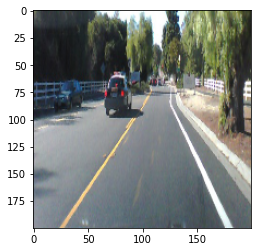

In [84]:
import matplotlib.pyplot as plt
img=get_input('driving_dataset/42000.jpg')
print(img.shape)
plt.imshow(img)

In [ ]:
from imgaug import augmenters as iaa

In [ ]:
path='driving_dataset/'
Train_pointer=0

In [ ]:
def train_data_generator(path,x_train,y_train,batch_size=100):
  global Train_pointer
  while True:
    ## Will output a x_train and y_train
    ## And the length of x_train and y_train will be equal to batch_size
    contrst=iaa.LinearContrast(alpha=(0.75,1.25))
    flipping=iaa.Flipud(1)
    x_t=[]
    y_t=[]
    for i in range(batch_size):
      img_name=x_train[(i+Train_pointer)%len(x_train)]
      #print(img_name)
      img_path=os.path.join(path,img_name)
      #print(img_path)
      img_data=get_input(img_path)
      steering_angle=y_train[(i+Train_pointer)%len(x_train)]
      ## Preprocessing
      '''temp=np.random.choice(2,p=[0.7,0.3])
      if(temp==0):
        img_data=flipping(images=img_data)
        steering_angle=-1*steering_angle
        img_data=contrst(images=img_data)'''
      x_t.append(img_data)
      y_t.append(steering_angle)
    x_t=np.array(x_t)
    y_t=np.array(y_t)
    temp=np.random.choice(2,p=[0.7,0.3])
    if(temp==0):
      #x_t=contrst(images=x_t)
      x_t=flipping(images=x_t)
      y_t=(-1)*y_t
    #x_t=contrst(images=x_t)
    ## Yielding result
    Train_pointer+=batch_size
    yield x_t,y_t

In [ ]:
Test_pointer=0

In [ ]:
def val_data_generator(path,x_test,y_test,batch_size=100):
  global Test_pointer
  while True:
    ## Will output a x_test and y_test
    ## And the length of x_test and y_test will be equal to batch_size
    x_t=[]
    y_t=[]
    for i in range(batch_size):
      img_name=x_test[(i+Test_pointer)%len(x_test)]
      img_path=os.path.join(path,img_name)
      img_data=get_input(img_path)
      x_t.append(img_data)
      y_t.append(y_test[(i+Test_pointer)%len(x_test)])
    x_t=np.array(x_t)
    y_t=np.array(y_t)
    Test_pointer+=batch_size
    yield x_t,y_t

In [ ]:
train_gen=train_data_generator(path,x_train,y_train)
val_gen=val_data_generator(path,x_test,y_test)

In [ ]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.layers import *
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
from keras.applications import MobileNet
from keras.applications import ResNet50

In [ ]:
#Model_1
model = Sequential()

model.add(Conv2D(24,(5,5),activation='relu',input_shape=(200,200,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(36,(5,5),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(48,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(1,activation='tanh',kernel_regularizer=regularizers.l2(0.01)))

model.summary()

model.compile(optimizer = Adam(0.00001),loss = 'mse',metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 196, 196, 24)      1824      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 98, 98, 24)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 98, 98, 24)        96        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 94, 94, 36)        21636     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 36)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 47, 47, 36)        144       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 48)       

In [ ]:
from keras.callbacks import ModelCheckpoint ## Saves the best model,fight overfitting
from keras.callbacks import EarlyStopping ## Saves time
checkpoint=ModelCheckpoint('drive/My Drive/Self_Driving_Car_Project/model_1.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='auto',period=1)

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=364,epochs=50,validation_data=val_gen,validation_steps=91,callbacks=[checkpoint])

Epoch 1/50
364/364 [==============================] - ETA: 0s - loss: 5.3516 - mae: 0.4212
Epoch 00001: val_loss improved from inf to 4.84096, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 199s 548ms/step - loss: 5.3516 - mae: 0.4212 - val_loss: 4.8410 - val_mae: 0.4972
Epoch 2/50
364/364 [==============================] - ETA: 0s - loss: 4.2659 - mae: 0.2632
Epoch 00002: val_loss improved from 4.84096 to 3.79383, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 199s 546ms/step - loss: 4.2659 - mae: 0.2632 - val_loss: 3.7938 - val_mae: 0.2428
Epoch 3/50
364/364 [==============================] - ETA: 0s - loss: 3.3702 - mae: 0.2124
Epoch 00003: val_loss improved from 3.79383 to 2.99174, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 198s 545ms/step - loss: 3.3702 - mae: 0.2124 - val_los

In [ ]:
model.load_weights('drive/My Drive/Self_Driving_Car_Project/')

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=364,epochs=10,validation_data=val_gen,validation_steps=91,callbacks=[checkpoint])

Epoch 1/10
364/364 [==============================] - ETA: 0s - loss: 0.1370 - mae: 0.0996
Epoch 00001: val_loss improved from inf to 0.19466, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 212s 583ms/step - loss: 0.1370 - mae: 0.0996 - val_loss: 0.1947 - val_mae: 0.1707
Epoch 2/10
364/364 [==============================] - ETA: 0s - loss: 0.1338 - mae: 0.0996
Epoch 00002: val_loss improved from 0.19466 to 0.18135, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 203s 558ms/step - loss: 0.1338 - mae: 0.0996 - val_loss: 0.1814 - val_mae: 0.1670
Epoch 3/10
364/364 [==============================] - ETA: 0s - loss: 0.1330 - mae: 0.1022
Epoch 00003: val_loss improved from 0.18135 to 0.16858, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 199s 547ms/step - loss: 0.1330 - mae: 0.1022 - val_los

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=364,epochs=10,validation_data=val_gen,validation_steps=91,callbacks=[checkpoint])

Epoch 1/10
364/364 [==============================] - ETA: 0s - loss: 0.1228 - mae: 0.0913
Epoch 00001: val_loss improved from inf to 0.17552, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 195s 537ms/step - loss: 0.1228 - mae: 0.0913 - val_loss: 0.1755 - val_mae: 0.1725
Epoch 2/10
364/364 [==============================] - ETA: 0s - loss: 0.1214 - mae: 0.0894
Epoch 00002: val_loss improved from 0.17552 to 0.16621, saving model to drive/My Drive/Self_Driving_Car_Project/final_test_4.h5
364/364 [==============================] - 195s 535ms/step - loss: 0.1214 - mae: 0.0894 - val_loss: 0.1662 - val_mae: 0.1621
Epoch 3/10
364/364 [==============================] - ETA: 0s - loss: 0.1208 - mae: 0.0889
Epoch 00003: val_loss did not improve from 0.16621
364/364 [==============================] - 193s 530ms/step - loss: 0.1208 - mae: 0.0889 - val_loss: 0.1675 - val_mae: 0.1585
Epoch 4/10
364/364 [=============================

In [ ]:
# Model_2

model = Sequential()

model.add(Conv2D(24,(5,5),activation='relu',input_shape=(128,128,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(36,(5,5),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(48,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())


model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(1,activation='tanh',kernel_regularizer=regularizers.l2(0.01)))

model.summary()

model.compile(optimizer = Adam(0.00001),loss = 'mse',metrics=['mae'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 124, 124, 24)      1824      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 62, 62, 24)        0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 62, 62, 24)        96        
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 58, 58, 36)        21636     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 29, 29, 36)        0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 29, 29, 36)        144       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 27, 27, 48)      

In [ ]:
from keras.callbacks import ModelCheckpoint ## Saves the best model,fight overfitting
from keras.callbacks import EarlyStopping ## Saves time
checkpoint=ModelCheckpoint('drive/My Drive/Self_Driving_Car_Project/model_2.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='auto',period=1)

In [ ]:
model.load_weights('drive/My Drive/Self_Driving_Car_Project/.h5')

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=364,epochs=10,validation_data=val_gen,validation_steps=91,callbacks=[checkpoint])

Epoch 1/10
364/364 [==============================] - ETA: 0s - loss: 0.1582 - mae: 0.1312
Epoch 00001: val_loss did not improve from 0.20490
364/364 [==============================] - 162s 446ms/step - loss: 0.1582 - mae: 0.1312 - val_loss: 0.2075 - val_mae: 0.2414
Epoch 2/10
364/364 [==============================] - ETA: 0s - loss: 0.1530 - mae: 0.1249
Epoch 00002: val_loss did not improve from 0.20490
364/364 [==============================] - 163s 447ms/step - loss: 0.1530 - mae: 0.1249 - val_loss: 0.2087 - val_mae: 0.2536
Epoch 3/10
364/364 [==============================] - ETA: 0s - loss: 0.1531 - mae: 0.1265
Epoch 00003: val_loss improved from 0.20490 to 0.20455, saving model to drive/My Drive/Self_Driving_Car_Project/time_pass.h5
364/364 [==============================] - 164s 452ms/step - loss: 0.1531 - mae: 0.1265 - val_loss: 0.2046 - val_mae: 0.2532
Epoch 4/10
364/364 [==============================] - ETA: 0s - loss: 0.1549 - mae: 0.1289
Epoch 00004: val_loss improved fro